In [1]:
#!pip install -r requirements.txt

In [1]:
import os
import time
import sys

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torchvision

from PIL import Image
import cv2

sys.path.append(str(Path('../..').resolve()))
from src.helper.cuda import check_cuda

C:\Users\simon\Desktop\repo\poc-megadetector-pipeline\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
check_cuda()

Checking for CUDA devices .....
CUDA Device available: [True]
|    | Name                               |   Major |   Minor |   Memory (MB) |   Multi Processor Count |
|---:|:-----------------------------------|--------:|--------:|--------------:|------------------------:|
|  0 | NVIDIA GeForce RTX 3060 Laptop GPU |       8 |       6 |       6441.93 |                      30 |


In [36]:
memory = {}
memory['start'] = torch.cuda.memory_allocated()
print(memory)

{'start': 0}


In [ ]:
# load model
model = torch.hub.load('ultralytics/yolov5:v6.2', 'custom', '../../model_weights/md_v5a.0.0.pt')
model.eval()

In [38]:
memory['Model'] = torch.cuda.memory_allocated()
print(memory)

{'start': 0, 'Model': 571224576}


In [ ]:
# load images
image_dir = Path('../../images/camtraps/')
sample_images = [str(f) for f in image_dir.glob('*.jpg')]
sample_images[:5]

['..\\..\\images\\camtraps\\1-s2.0-S2215016120302624-gr5.jpg',
 '..\\..\\images\\camtraps\\1.-camera-trap.jpg',
 '..\\..\\images\\camtraps\\13TB-LIONS1-videoSixteenByNine3000-v3.jpg',
 '..\\..\\images\\camtraps\\1cac1ca0-5520-46ff-928f-1481efad5dcd_large.JPG.jpg',
 '..\\..\\images\\camtraps\\1_camera_trap.jpg']

In [ ]:
# stop time for batched MegaDetector
NRUNS = 5
BATCHSIZE = 8
all_images = np.array([cv2.imread(f)[:, :, ::-1] for f in sample_images])
times = []

with tqdm(total=NRUNS*all_images.shape[0]//BATCHSIZE) as pbar:
    start_time = time.perf_counter()
    for _ in range(NRUNS):
        for batch in np.array_split(all_images, all_images.shape[0]//BATCHSIZE):
            batch = batch.tolist()
            results = model(batch, size=1280)
            pbar.update(1)

        end_time = time.perf_counter() - start_time
        times.append(end_time)

/tmp/ipykernel_233/1839511806.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_images = np.array([cv2.imread(f)[:, :, ::-1] for f in sample_images])
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65/66 [02:29<00:02,  2.30s/it]


In [ ]:
memory = {}
memory['after_inference'] = torch.cuda.memory_allocated()
print(memory)

{'after_inference': 932280832}


In [ ]:
print(f'Mean Time: {np.mean(times).round(2)} Seconds for {len(sample_images)} Images')
print(f'Mean Time: {(np.mean(times)/len(sample_images)).round(2)} Seconds for 1 Image')

Mean Time: 112.59 Seconds for 106 Images
Mean Time: 1.06 Seconds for 1 Image


In [18]:
# stop time for batched MegaDetector
NRUNS = 5
all_images = np.array([cv2.imread(f)[:, :, ::-1] for f in sample_images])
times = []

with tqdm(total=NRUNS*all_images.shape[0]) as pbar:
    start_time = time.perf_counter()
    for _ in range(NRUNS):
        for f in sample_images:
            im2 = cv2.imread(f)[:,:,::-1]  # OpenCV image (BGR to RGB)
            results = model([im2], size=1280) # batch of images
            pbar.update(1)
        end_time = time.perf_counter() - start_time
        times.append(end_time)

/tmp/ipykernel_233/3792957416.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_images = np.array([cv2.imread(f)[:, :, ::-1] for f in sample_images])
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [02:22<00:00,  3.73it/s]


In [19]:
torch.cuda.empty_cache()

In [20]:
print(f'Mean Time: {np.mean(times).round(2)} Seconds for {len(sample_images)} Images')
print(f'Mean Time: {(np.mean(times)/len(sample_images)).round(2)} Seconds for 1 Image')

Mean Time: 64.76 Seconds for 106 Images
Mean Time: 0.61 Seconds for 1 Image


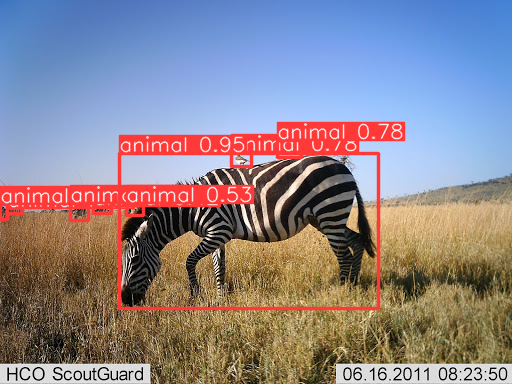

In [21]:
results.show()

In [22]:
results.print()

image 1/1: 384x512 8 animals
Speed: 7.4ms pre-process, 442.2ms inference, 2.3ms NMS per image at shape (1, 3, 960, 1280)


In [40]:
res = results.pandas().xyxy[0]

NameError: name 'results' is not defined

In [58]:
res= []
for f in tqdm(sample_images, disable=False):
    im2 = cv2.imread(f)[:,:,::-1]  # OpenCV image (BGR to RGB)
    results = model([im2], size=1280) # batch of images
    results = results.pandas().xyxy[0]
    results['filename'] = f
    res.append(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:16<00:00,  6.61it/s]


In [64]:
res[]

,xmin,ymin,xmax,ymax,confidence,class,name,filename
0,168.269684,464.915527,275.872650,627.841431,0.845027,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
1,439.836731,462.383484,622.902161,585.181091,0.824054,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
2,67.376122,386.266693,109.276985,449.901215,0.796369,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
3,28.310318,394.254547,61.094154,454.529816,0.786667,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
4,0.000000,407.177765,32.763382,457.210663,0.785514,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
5,1228.126465,422.539551,1280.000000,478.126648,0.779720,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
6,1011.203308,418.616272,1051.324097,473.333374,0.777574,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
7,748.491760,423.618866,835.497375,530.048401,0.776094,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
8,974.429016,454.050598,1126.122070,590.886414,0.769217,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
9,215.835022,429.509399,280.258728,526.348816,0.766395,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...


In [67]:
pd.concat(res).reset_index(drop=True)

,xmin,ymin,xmax,ymax,confidence,class,name,filename
0,8.988580,92.247482,254.579163,287.793274,0.941215,0,animal,..\..\images\camtraps\1-s2.0-S2215016120302624...
1,1597.979614,1653.638672,1778.552490,2715.949951,0.337796,1,person,..\..\images\camtraps\1.-camera-trap.jpg
2,1700.772949,225.972473,2586.374756,1349.696045,0.971223,0,animal,..\..\images\camtraps\13TB-LIONS1-videoSixteen...
3,168.269684,464.915527,275.872650,627.841431,0.845027,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
4,439.836731,462.383484,622.902161,585.181091,0.824054,0,animal,..\..\images\camtraps\1cac1ca0-5520-46ff-928f-...
...,...,...,...,...,...,...,...,...
214,126.409500,203.198578,143.934921,215.633713,0.533478,0,animal,..\..\images\camtraps\zebra.jpg
215,70.888268,203.537094,88.607147,220.141678,0.501795,0,animal,..\..\images\camtraps\zebra.jpg
216,93.560600,206.996750,111.130859,213.774826,0.422679,0,animal,..\..\images\camtraps\zebra.jpg
217,0.015993,204.819366,7.138619,219.432297,0.344432,0,animal,..\..\images\camtraps\zebra.jpg


In [48]:
pd.concat([r.pandas().xyxy[0] for r in res])

,xmin,ymin,xmax,ymax,confidence,class,name
0,8.988580,92.247482,254.579163,287.793274,0.941215,0,animal
0,1597.979614,1653.638672,1778.552490,2715.949951,0.337796,1,person
0,1700.772949,225.972473,2586.374756,1349.696045,0.971223,0,animal
0,168.269684,464.915527,275.872650,627.841431,0.845027,0,animal
1,439.836731,462.383484,622.902161,585.181091,0.824054,0,animal
...,...,...,...,...,...,...,...
3,126.409500,203.198578,143.934921,215.633713,0.533478,0,animal
4,70.888268,203.537094,88.607147,220.141678,0.501795,0,animal
5,93.560600,206.996750,111.130859,213.774826,0.422679,0,animal
6,0.015993,204.819366,7.138619,219.432297,0.344432,0,animal
